In [1]:
import os
import re
from scipy import stats
import tempfile
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import rgb2hex
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
import sys
import seaborn as sns
sys.path.append('../../CEBRA_analysis/')
from dataset_load import data_load
from scipy.stats import mannwhitneyu, normaltest, ttest_ind, levene, ttest_rel, shapiro

In [2]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]

In [3]:
data_dict = data_load(input_folder, variables_to_drop, skipdates)
x = data_dict["X_pd"]
y = data_dict["y_pd"]
animals_id = data_dict["animals_id_pd"]
run_id = data_dict["run_id_pd"]

No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [4]:
a = np.asarray([[1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9]])
a[1, [1,2,3]]

array([2, 3, 4])

In [5]:
def split_train_lda(x, y, animals_id, run_id, idxs):
    groups = [a+i for a, i in zip(animals_id, run_id)]
    
    rng = np.random.default_rng(seed=42)  # for reproducibility
    unique_groups = np.unique(groups)      # array of shape (55,)
    rng.shuffle(unique_groups)   
    
    
    gkf = GroupKFold(n_splits=11)
    gkf.get_n_splits(groups=groups)
    
    X_unique = np.arange(len(unique_groups))
    
    true = []
    predictions = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_unique, groups=unique_groups)):
    
        train_groups = unique_groups[train_idx]
        test_groups  = unique_groups[test_idx]
        
        train_mask = np.isin(groups, train_groups)
        test_mask  = np.isin(groups, test_groups)
        
        X_train, y_train = x.iloc[train_mask, idxs], y[train_mask]
        X_test,  y_test  = x.iloc[test_mask, idxs],  y[test_mask]
    
        clf = LinearDiscriminantAnalysis(store_covariance=True, n_components=2)
        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        true.append(y_test)
        predictions.append(prediction)
    return true, predictions

 # NEURAL SECTION 

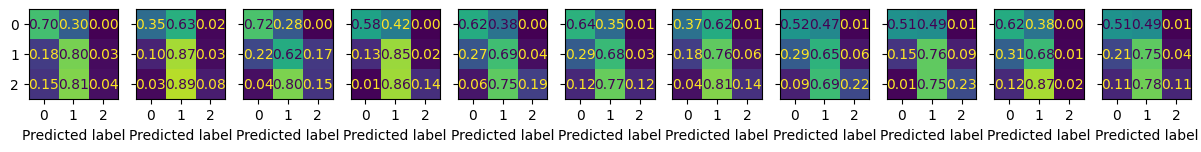

In [6]:
s = slice(36, None)
true, predictions = split_train_lda(x, y, animals_id, run_id, idxs=s)
confusion_matrixes = []

for i in range(11):
    cm = confusion_matrix(true[i], predictions[i], labels=[0,1,2], normalize="true")
    confusion_matrixes.append(cm)
pd_avg_confusion_matrixes = np.mean(confusion_matrixes, axis=0)
pd_std_confusion_matrixes = np.std(confusion_matrixes, axis=0)

fig, axs = plt.subplots(1, len(confusion_matrixes), figsize=(15,7), sharey=True)
for i, cm in enumerate(confusion_matrixes):
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1,2])
    disp.plot(ax=axs[i], colorbar=False, values_format=".2f")
    disp.im_.set_clim(vmin=0, vmax=1)
    axs[i].set_ylabel("")

Text(0, 0.5, '')

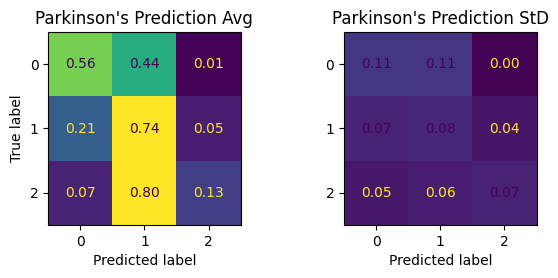

In [7]:
fig, axs = plt.subplots(1,2, figsize=(7,2.5))

disp = ConfusionMatrixDisplay(confusion_matrix=pd_avg_confusion_matrixes, display_labels=[0,1,2])
disp.plot(ax=axs[0], colorbar=False, values_format=".2f")
disp.im_.set_clim(vmin=0, vmax=0.7)
axs[0].set_title("Parkinson's Prediction Avg")


disp = ConfusionMatrixDisplay(confusion_matrix=pd_std_confusion_matrixes, display_labels=[0,1,2])
disp.plot(ax=axs[1], colorbar=False, values_format=".2f")
disp.im_.set_clim(vmin=0, vmax=0.7)
axs[1].set_title("Parkinson's Prediction StD")
axs[1].set_ylabel("")




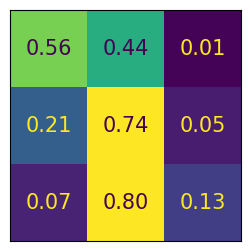

In [8]:
fig, ax = plt.subplots(figsize=(3,3))
text_kw = {"fontsize":15}
disp = ConfusionMatrixDisplay(confusion_matrix=pd_avg_confusion_matrixes, display_labels=[0,1,2])
disp.plot(ax=ax, colorbar=False, values_format=".2f", text_kw=text_kw)
disp.im_.set_clim(vmin=0, vmax=0.7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([], [])
ax.set_yticks([], [])
plt.savefig("pd_neural_cm.png", transparent=True)
plt.savefig("pd_neural_cm.svg", transparent=True)

In [9]:
s = slice(36, None)
x_fit=x.iloc[:, s]
clf = LinearDiscriminantAnalysis(store_covariance=True, n_components=2)
clf.fit(x_fit, y)
prediction = clf.predict(x_fit)

df_scalings = pd.DataFrame(clf.scalings_, columns=["x", "y"])
df_scalings["magn"] = np.sqrt(df_scalings["x"]**2 + df_scalings["y"]**2)
df_scalings["feats"] = x_fit.columns

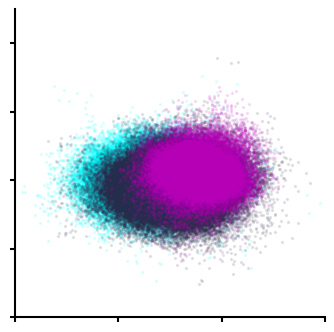

In [19]:
x_trans = clf.transform(x_fit)
fig, ax = plt.subplots(figsize=(4,4))
palette = ["#262626","#3560ac","#3F5264"]
colors = ["cyan", "#2e2d4d", "m"]

feat_n = 5


for color, i, target_name in zip(colors, [0, 1, 2], y):
    sc=ax.scatter(
        x_trans[y == i, 0], x_trans[y == i, 1], alpha=0.1, color=color, label=i, s=2
    )
feats = x_fit.columns[df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].index]
#colors = [palette[0] if i>36 else palette[1] for i in df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].index]


sc.set_rasterized(True)
#plt.legend(loc=[1,0])
ax.set_ylim(-7.5, 10)
ax.set_xlim(-6, 5)

ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[], fontsize=15)

#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)


plt.savefig("lda_neural_scatter.png", transparent=True,dpi=300)

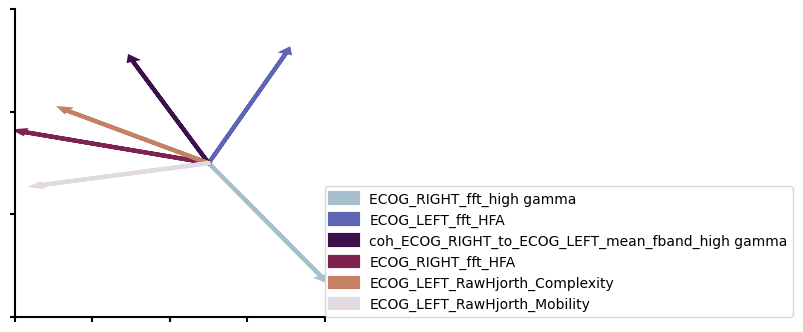

In [11]:
x_trans = clf.transform(x_fit)
fig, ax = plt.subplots(figsize=(4,4))
palette = ["#262626","#3560ac","#3F5264"]
cmap = plt.get_cmap('twilight')
cmap = cmap(np.linspace(0.1, 1, 6))
colors = ["cyan", "#2e2d4d", "m"]

feat_n = 6

feats = x_fit.columns[df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].index]
for i, val in enumerate(df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].values):
    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=feats[i], alpha=1, color=cmap[i], head_width=0.3, head_length=0.3)

sc.set_rasterized(True)
plt.legend(loc=[1,0])
#ax.set_ylim(-10, 10)
ax.set_xlim(-9, 5)

ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[], fontsize=15)

#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_neural_arrows.png", transparent=True)

In [12]:

#fig, ax = plt.subplots()
#
#colors = ["cyan", "#2e2d4d", "m"]
#feat_n = 6
#
#for color, i, target_name in zip(colors, [0, 1, 2], y_test):
#    ax.scatter(
#        x_trans[y == i, 0], x_trans[y == i, 1], alpha=0.1, color=color, label=i, s=2)
#feats = x_fit.columns[df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].index]
#colors = [palette[0] if i>36 else palette[1] for i in df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].index]
#neural_count = 0
#for i, val in enumerate(df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].values):
#    if colors[i] == "#262626":
#        neural_count+=1
#    if neural_count>3 and colors[i] == "#262626":
#        continue
#    ax.plot([0, val[0]*10], [0, val[1]*10], linewidth=3, label=feats[i], alpha=1)
#
#plt.legend(loc=[1,0])

# KINEMATIC SECTION

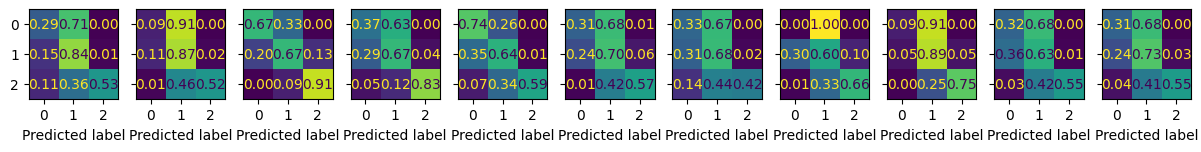

In [13]:
s = slice(None, 36)
true, predictions = split_train_lda(x, y, animals_id, run_id, idxs=s)
confusion_matrixes = []

for i in range(11):
    cm = confusion_matrix(true[i], predictions[i], labels=[0,1,2], normalize="true")
    confusion_matrixes.append(cm)
h_avg_confusion_matrixes = np.mean(confusion_matrixes, axis=0)
h_std_confusion_matrixes = np.std(confusion_matrixes, axis=0)

fig, axs = plt.subplots(1, len(confusion_matrixes), figsize=(15,7), sharey=True)
for i, cm in enumerate(confusion_matrixes):
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1,2])
    disp.plot(ax=axs[i], colorbar=False, values_format=".2f")
    disp.im_.set_clim(vmin=0, vmax=1)
    axs[i].set_ylabel("")

Text(0, 0.5, '')

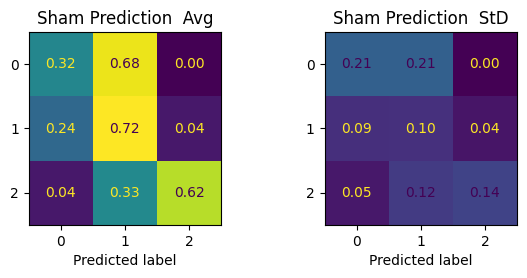

In [14]:
fig, axs = plt.subplots(1,2, figsize=(7,2.5))

disp = ConfusionMatrixDisplay(confusion_matrix=h_avg_confusion_matrixes, display_labels=[0,1,2])
disp.plot(ax=axs[0], colorbar=False, values_format=".2f")
disp.im_.set_clim(vmin=0, vmax=0.7)
axs[0].set_title("Sham Prediction  Avg")
axs[0].set_ylabel("")


disp = ConfusionMatrixDisplay(confusion_matrix=h_std_confusion_matrixes, display_labels=[0,1,2])
disp.plot(ax=axs[1], colorbar=False, values_format=".2f")
disp.im_.set_clim(vmin=0, vmax=0.7)
axs[1].set_title("Sham Prediction  StD")
axs[1].set_ylabel("")

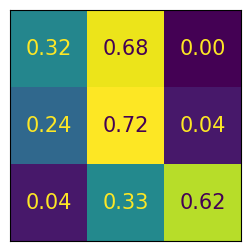

In [15]:
fig, ax = plt.subplots(figsize=(3,3))
text_kw = {"fontsize":15}
disp = ConfusionMatrixDisplay(confusion_matrix=h_avg_confusion_matrixes, display_labels=[0,1,2])
disp.plot(ax=ax, colorbar=False, values_format=".2f", text_kw=text_kw)
disp.im_.set_clim(vmin=0, vmax=0.7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([], [])
ax.set_yticks([], [])
plt.savefig("pd_kin_cm.png", transparent=True)
plt.savefig("pd_kin_cm.svg", transparent=True)

In [16]:
h_avg_confusion_matrixes

array([[0.32000325, 0.67849489, 0.00150186],
       [0.2356214 , 0.71969115, 0.04468745],
       [0.0448381 , 0.33055017, 0.62461173]])

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

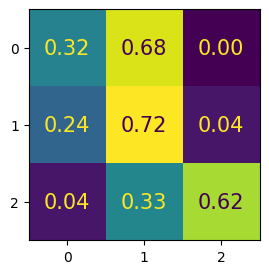

In [17]:
fig, ax = plt.subplots(figsize=(3,3))
text_kw = {"fontsize":15}
disp = ConfusionMatrixDisplay(confusion_matrix=h_avg_confusion_matrixes, display_labels=[0,1])
disp.plot(ax=ax, colorbar=False, values_format=".2f", text_kw=text_kw)
disp.im_.set_clim(vmin=0, vmax=0.7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([], [])
ax.set_yticks([], [])
plt.savefig("pd_kin_cm_2.png", transparent=True)
plt.savefig("pd_kin_cm_2.svg", transparent=True)

In [ ]:
s = slice(None, 36)
x_fit=x.iloc[:, s]
clf = LinearDiscriminantAnalysis(store_covariance=True)
clf.fit(x_fit, y)
prediction = clf.predict(x_fit)

df_scalings = pd.DataFrame(clf.scalings_, columns=["x", "y"])
df_scalings["magn"] = np.sqrt(df_scalings["x"]**2 + df_scalings["y"]**2)
df_scalings["feats"] = x_fit.columns

In [ ]:

fig, ax = plt.subplots(figsize=(4,4))
palette = ["#262626","#3560ac","#3F5264"]
colors = ["cyan", "#2e2d4d", "m"]
cmap = plt.get_cmap('twilight')
cmap = cmap(np.linspace(0.1, 1, 6))


feat_n = 6
df_scalings.sort_values(by="magn", inplace=True, ascending=False)

#feats = x_fit.columns[df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].index]
#colors = [palette[0] if i>36 else palette[1] for i in df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].index]

permutations_feat = ['rshoulder_speed_mean', 'lshoulder_speed_mean', 'rcrest_speed_mean',
       'rhip_speed_mean', 'rknee_speed_mean']


vals=df_scalings.iloc[:feat_n].values
vals = [permutations_feat]
feats=df_scalings["feats"].iloc[:feat_n].values
feats = permutations_feat
for i, val in enumerate(vals):
    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=feats[i], alpha=1, color=cmap[i], head_width=0.3, head_length=0.3)

sc.set_rasterized(True)
plt.legend(loc=[1,0])
#ax.set_ylim(-10, 10)
ax.set_xlim(-5, 8)

ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[], fontsize=15)

ax.spines[['right', 'top']].set_visible(False)

ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)


plt.savefig("lda_kinematic_arrows.png", transparent=True)

In [ ]:

fig, ax = plt.subplots()

colors = ["cyan", "#2e2d4d", "m"]
feat_n = 6

for color, i, target_name in zip(colors, [0, 1, 2], y):
    ax.scatter(
        x_trans[y == i, 0], x_trans[y == i, 1], alpha=0.1, color=color, label=i, s=2)
feats = x_fit.columns[df_scalings.sort_values(by="magn").iloc[:feat_n].index]
colors = [palette[0] if i>36 else palette[1] for i in df_scalings.sort_values(by="magn")[::-1].iloc[:feat_n].index]
neural_count = 0
for i, val in enumerate(df_scalings.sort_values(by="magn").iloc[:feat_n].values):
    if colors[i] == "#262626":
        neural_count+=1
    if neural_count>3 and colors[i] == "#262626":
        continue
    ax.plot([0, val[0]*10], [0, val[1]*10], linewidth=3, label=feats[i], alpha=1)

plt.legend(loc=[1,0])